# Appendix: An interactive Jupyter notebook session to accompany: "Penney's game odds from no-arbitrage" by Miller, J.B. (2019)


see XX for .ipynb and .py files.

See Appendix B below for conway.py source code. 



This interactive notebook explores an algorithm that solves a generalized version of Penney's pattern-matching game for a q-sided die ($q\geq 3$), with potentially unequal probabilities.

The solution implements a generalized version of Conway's leading number algorithm , and cross-validates it via simulation.

References
1. Miller, J.B. (2019) "Penney's game odds: a no-arbitrage argument", Arxiv [PDF Download]()
2. Li, Shuo-Yen Robert. (1980) A martingale approach to the study of occurrence of sequence patterns in repeated experiments." _the Annals of Probability_, 8(6) 1171-1176. [PDF Download](https://projecteuclid.org/euclid.aop/1176994578)
3. Guibas, L. J. & Odlyzko, A. M. (1981), "String overlaps, pattern matching, and nontransitive games",
 _Journal of Combinatorial Theory, Series A_ 30(2), 183--208. [PDF Download](https://core.ac.uk/download/pdf/81142890.pdf)
2. 

# Conway.py source code:

In [51]:
#!/usr/bin/env python

''' 
conway.py: For solving generalized Penney's game with 
generalized Conway formula, including simulations.

For background, see Miller(2019) '' 
'''

import numpy as np


__author__ = "Joshua B. Miller"
__copyright__ = "Creative Commons"
__credits__ = "none"
__license__ = "GPL"
__version__ = "0.0.1"
__maintainer__ = "Joshua B. Miller"
__email__ = "joshua.benjamin.miller@gmail.com"
__status__ = "Prototype"


def payoff_to_B_bets_if_A_occurs_first(A,B,alphabet):
    ''' (string, string, dictionary)-> (float)
    The fair payoff to all B bets if pattern A appears first.
    This function calculates the fair payoff to someone who initiates a 
    fresh sequence of bets each period in which bets anticipate pattern B

    note: Assuming the sequence ends at trial t>len(B), then when pattern A occurs
    there will be up to len(B) ongoing, and overlapping, B-bet sequences  .

    For example:
    >>>A='THH'
    >>>B='HHH'
    >>>alphabet={'T':.5, 'H':.5})
    >>>AB=payoff_to_B_bets_if_A_occurs_first(A,B,alphabet)
    Then in this case AB=4+2=6 as B betters who enter at T-2 lose immediately,
    those who enter at T-1 win twice,   and those who enter at T win once. 


    '''
    #make sure alphabet is a valid categorical distribution
    #(tolerate 1e-10 deviation; not too strict on the sum for precision issues)
    if abs(sum(alphabet.values())-1) > 1e-10:
        raise Exception("Alphabet is not a valid probability distribution")

    #make sure keys are strings
    if any( type(el) is not str for el in alphabet.keys() ) :
        raise Exception("only strings please")
    
    #make sure strings are of length 1
    if any( len(el)>1 for el in alphabet.keys() ) :
        raise Exception("Strings must be length 1")


    #Make sure all characters in the patterns appear in the Alphabet
    if any(char not in alphabet.keys() for char in A+B  ):
        raise Exception("All chacters must appear in the Alphabet")

    #make sure B is not a strict substring of A (or it will appear first for sure) 
    # and vice-versa
    if ( len(B)<len(A) and A.find(B)>-1) or ( len(A)<len(B) and B.find(A)>-1):
        raise Exception("one string cannot be a strict substring of another")
    
    # Calculate AB, the total payoffs from each sequence of bets anticipating pattern B
    # that are still active when the sequence stops at A
    AB = 0
    for i in range(len(A)):
        A_trailing = A[i:]
        B_leading = B[0:len(A_trailing)]
        if A_trailing == B_leading:
            #The sequence of bets anticipating B that are initiated at i (relatively)
            #need to be paid when A occurs if there is perfect overlap of the leading characters of B 
            # with the trailing characters of A
            #Why?The person waiting for B to occcur hasn't gone bankrupt yet, 
            #This person gets paid for betting correctly on every realization in A_trailing

            #On bet i, "wealth" is the amount invested predicting the event A_trailing[i],
            #this investment gets a fair gross rate of return
            #equal to the inverse of the probability of the event (1/alphabet[A_trailing[i]])
            wealth=1
            for i in range(len(A_trailing)):
                gross_return = 1/alphabet[A_trailing[i]]
                wealth = wealth*gross_return
            AB = AB + wealth
    return AB

def oddsAB(A,B,alphabet):
    ''' (string, string, dictionary)-> [list]
    returns odds against pattern A preceding pattern B
    odds[0] = "chances against A"
    odds[1] = "chances in favor of A"
    
    note: odds= 2* Conway's odds; see Miller (2019) for proof
    '''
 
    if A==B:
        raise Exception("A==B; patterns cannot precede themselves")
    elif ( len(B)<len(A) and A.find(B)>-1): #if B is strict substring of A
        odds = [1,0]    
    elif ( len(A)<len(B) and B.find(A)>-1): #if A is strict substring of B
        odds = [0,1] 
    else:
        AA=  payoff_to_B_bets_if_A_occurs_first(A,A,alphabet)
        AB = payoff_to_B_bets_if_A_occurs_first(A,B,alphabet)
        BB = payoff_to_B_bets_if_A_occurs_first(B,B,alphabet)
        BA = payoff_to_B_bets_if_A_occurs_first(B,A,alphabet)
        odds = [AA-AB , BB-BA]

    return odds

def probAB(A,B,alphabet):
    ''' (string, string, dictionary)-> (float)
            probability pattern A precedes pattern B
            note: odds are o[0] chances against for every o[1] chances in favor
            there are o[0]+o[1]
    '''
    o = oddsAB(A,B,alphabet)
    return o[1]/(o[0]+o[1])

def expected_waiting_time(A,B,alphabet):
    ''' (string, string, dictionary)-> (float)
            expected waiting time until the first occurance of A or B
            see Miller (2019) for derivation
    '''

    if A==B:
        wait = payoff_to_B_bets_if_A_occurs_first(A,A,alphabet)
    elif ( len(B)<len(A) and A.find(B)>-1): #if B is strict substring of A
        wait = payoff_to_B_bets_if_A_occurs_first(B,B,alphabet) 
    elif ( len(A)<len(B) and B.find(A)>-1): #if A is strict substring of B
        wait = payoff_to_B_bets_if_A_occurs_first(A,A,alphabet)
    else:
        AA=  payoff_to_B_bets_if_A_occurs_first(A,A,alphabet)
        AB = payoff_to_B_bets_if_A_occurs_first(A,B,alphabet)
        BB = payoff_to_B_bets_if_A_occurs_first(B,B,alphabet)
        BA = payoff_to_B_bets_if_A_occurs_first(B,A,alphabet)
        wait = (AA*BB - AB*BA)/(AA + BB - AB - BA)
    return wait

def simulate_winrates_penney_game(A,B,alphabet,number_of_sequences):
    '''
    (string, string, dictionary, integer)-> (list)
    Play generalized Penney's game and calculate how often
    pattern A precedes pattern B, and vice versa

    '''
    N = number_of_sequences
    
    #The letters in the dicitonary have a categorical distribution
    #defined by the key, value pairs
    outcomes = list(alphabet.keys())
    probabilities = list(alphabet.values())
    
    n_wins = np.array([0, 0])
    n_flips = 0
    
    for i in range(N):
        max_length=max(len(A),len(B))
        window = ['!']* max_length
        #on each experiment draw from dictionary until either pattern A,
        # or pattern B appears
        while True:
            window.pop(0)
            draw=np.random.choice(outcomes, 1, replace=True, p=probabilities)
            n_flips += 1
            window.append(draw[0])
            ch_window = "".join(map(str,window))
            if ch_window[max_length-len(A):] == A:
                n_wins[0] += 1
                break
            elif ch_window[max_length-len(B):] == B:
                n_wins[1] += 1
                break

    winrates = n_wins/N
    av_n_flips = n_flips/N
    return winrates, av_n_flips

def all_patterns(j,alphabet):
    '''
    recusively builds all patterns of length j from alphabet
    note: before calling must initialize following two lists within module:
    >>>k=3
    >>>conway.list_pattern=['-']*k
    >>>conway.patterns = []
    >>>conway.all_patterns(k,alphabet)
    >>>patterns = conway.patterns
    '''
    global list_pattern
    global patterns
    if j == 1:
        for key in alphabet.keys():
            list_pattern[-j] = key
            string_pattern = ''.join(list_pattern)
            patterns.append(string_pattern)
    else:
        for key in alphabet.keys():
            list_pattern[-j] = key
            all_patterns(j-1,alphabet)



### Third party modules and directory check

In [1]:
import time
import os        #for benchmarking
import numpy as np
#in case we need to update user-defined code e.g. importlib.reload(diffP)
import importlib


In [32]:
current_dir=os.getcwd()
print(current_dir)
for file in os.listdir(current_dir):
    if file[-3:]=='.py':
        print(file)

C:\Users\Miller\Dropbox\josh\work\projects\Patterns\python
conway.py


### Desciption of code in "conway.py"

In [2]:
import conway  #The programs live here
importlib.reload(conway)
#help(conway)
print('Locked and loaded')

Locked and loaded


## Inspect functions

### Let's test the generalized Conway leading number

note: In the speccial case of a fair coin flip, this is $2\times \text{Conway Leading Number}$

Conway leading number is an (asymmetric) measure of overlap between two patterns A and B.

AB measures how the leading numbers of B overlap with the trailing numbers of A, as B is shifted to the right (assuming B is not a subpattern of A)

Here is the function:

In [6]:
help(conway.payoff_to_B_bettors_if_A_occurs_first)

Help on function payoff_to_B_bettors_if_A_occurs_first in module conway:

payoff_to_B_bettors_if_A_occurs_first(A, B, alphabet)
    (string, string, dictionary)-> (float)
    Calculates the fair payoff to those betting on characters according 
    to pattern B, if pattern A occurs first.
    
    For example:
    >>>A='THH'
    >>>B='HHH'
    >>>alphabet={'T':.5, 'H':.5})
    >>>AB=payoff_to_B_bettors_if_A_occurs_first(A,B,alphabet)
    Then in this case AB=4+2=6 as B betters who come in at T-1 win twice, 
    and those that come in at T win once.



If A=THH comes first, how much does a player who, on each trial, initiates a asequence of bets on characters according to B=HHH, get paid?

The players that arrive at time T-1 and time T walk out with \$4 and \$2 respectively, for a total of \$6


In [17]:
distribution={'H':.5, 'T':.5}
A = "THH"
B = "HHH"
print(conway.payoff_to_B_bets_if_A_occurs_first(A, B, distribution))

6.0


### Let's test the generalized Conway leading number algorithm

Here is the function:

In [18]:
help(conway.oddsAB)

Help on function oddsAB in module conway:

oddsAB(A, B, alphabet)
    (string, string, dictionary)-> [list]
    returns odds against pattern A preceding pattern B
    odds[0] = "chances against A"
    odds[1] = "chances in favor of A"
    
    note: odds= 2* Conway's odds; see Miller (2019) for proof



What are the odds that that pattern A=HTH precedes pattern B=TTH?

In the case that A occurs before B, i.e we compare the trailing characters of $A\cdot$
* $AA=8+0+2=10$        (the $A$-bets initiated at $T-2$ and $T$ are winners)
* $AB=0+0+0=0$    (the $B$-bets never win)

In the case that B occurs before A, i.e we compare the trailing characters of $B\cdot$
* $BB=8+0+0=8$ (the $B$-bet inititiated at $T-2$ is a winner)
* $BA=0+0+2=2$        (the $A$-bet initiated at $T$ is a winner)

so odds against $A$ occuring before $B$ are ${AA-AB}:{BB-BA} = 10:6$, or $5:3$

this translates to a probability that $A$ occurs first equal to $3/8$

Let's check this below:

In [19]:
distribution={'H':.5, 'T':.5}
A = "HTH"
B = "TTH"
print('odds against A = [chances against, chances in favor] = ',conway.oddsAB(A, B, distribution))

print('probability A occurs before B = ', conway.probAB(A, B, distribution))


odds against A = [chances against, chances in favor] =  [10.0, 6.0]
probability A occurs before B =  0.375


## Cross-Validating the code.



### Replicating original Penney's Game odds (patterns of length 3)


Let's create the table, the probability the row pattern comes before the column pattern, and cross-validate with table from Gardner


In [97]:
from fractions import Fraction

pH = .5
pT = 1-pH
distribution={'H':pH, 'T':pT}

k = 3
#initialize the globals within the module
conway.list_pattern=['-']*k
conway.patterns = []

#build the patterns
help(conway.all_patterns)
conway.all_patterns(k,distribution)

patterns = conway.patterns

print("all patterns of length",k,"= ",patterns)


row = 0
print("-" * 70)
print("", end='\t')
print(*patterns, sep='\t')

while row < 8:
    col = 0
    print(patterns[row],end='\t')
    while col <= 7:
        r='\t'
        if col ==7:
            r='\n'
        if patterns[row]==patterns[col]:
           print('', end=r) 
        else:
            o=conway.oddsAB(patterns[row],patterns[col], distribution)
            F = Fraction(int(o[1]),int(o[0]+o[1]))
            N = F.numerator
            D = F.denominator
            print(N,"/",D,end=r)
        col += 1
    row += 1
print("-" * 70)



Help on function all_patterns in module conway:

all_patterns(j, alphabet)
    recusively builds all patterns of length j from alphabet
    note: before calling must initialize following two lists:
    >>>k=3
    >>>list_pattern=['-']*k
    >>>patterns = []

all patterns of length 3 =  ['HHH', 'HHT', 'HTH', 'HTT', 'THH', 'THT', 'TTH', 'TTT']
----------------------------------------------------------------------
	HHH	HHT	HTH	HTT	THH	THT	TTH	TTT
HHH		1 / 2	2 / 5	2 / 5	1 / 8	5 / 12	3 / 10	1 / 2
HHT	1 / 2		2 / 3	2 / 3	1 / 4	5 / 8	1 / 2	7 / 10
HTH	3 / 5	1 / 3		1 / 2	1 / 2	1 / 2	3 / 8	7 / 12
HTT	3 / 5	1 / 3	1 / 2		1 / 2	1 / 2	3 / 4	7 / 8
THH	7 / 8	3 / 4	1 / 2	1 / 2		1 / 2	1 / 3	3 / 5
THT	7 / 12	3 / 8	1 / 2	1 / 2	1 / 2		1 / 3	3 / 5
TTH	7 / 10	1 / 2	5 / 8	1 / 4	2 / 3	2 / 3		1 / 2
TTT	1 / 2	3 / 10	5 / 12	1 / 8	2 / 5	2 / 5	1 / 2	
----------------------------------------------------------------------


Gardner's table (they match):



<img src="Gardner-penney-table.PNG" align="left" alt="drawing" width="450"/>

### Cross-validate the odds function by simulation

here is the simulation function:

In [11]:
help(conway.simulate_winrates_penney_game)

Help on function simulate_winrates_penney_game in module conway:

simulate_winrates_penney_game(A, B, alphabet, number_of_trials)
    (string, string, dictionary, integer)-> (list)
    Play generalized Penney's game and calculate how often
    pattern A precedes pattern B, and vice versa



Cross-validate the simple case

In [258]:
distribution={'H':.5, 'T':.5}
A = "HTH"
B = "TTH"


p = conway.probAB(A,B,distribution)
wait = conway.expected_waiting_time(A,B,distribution)

N=10000
np.random.seed(0)
prop, average_n_flips= conway.simulate_winrates_penney_game(A,B,distribution,N)

print('Pr(A<B)   = ', "%.3f" %p , '   (Theoretical Probability)')
print('Prop(A<B) = ', "%.3f" %prop[0], '   (Simulation with N =', N, ' trials)\n')
print('E[number of flips] = ', "%.2f" %wait , '        (Theoretical Expectation)') 
print('Average number of flips = ', "%.2f" %average_n_flips, '   (Simulation with N =', N, ' trials)')

Pr(A<B)   =  0.375    (Theoretical Probability)
Prop(A<B) =  0.383    (Simulation with N = 10000  trials)

E[number of flips] =  5.00         (Theoretical Expectation)
Average number of flips =  5.00    (Simulation with N = 10000  trials)


Let's cross validate generalized Conway w/small alphabet & unequal probalities:

The simulation validates the formula

In [259]:
distribution={'H':.75, 'T':.25}
A = "HTH"
B = "TTH"

p = conway.probAB(A,B,distribution)
wait = conway.expected_waiting_time(A,B,distribution)

N=10000
np.random.seed(0)
prop, average_n_flips= conway.simulate_winrates_penney_game(A,B,distribution,N)

print('Pr(A<B)   = ', "%.3f" %p , '   (Theoretical Probability)')
print('Prop(A<B) = ', "%.3f" %prop[0], '   (Simulation with N =', N, ' trials)\n')
print('E[number of flips] = ', "%.2f" %wait , '        (Theoretical Expectation)') 
print('Average number of flips = ', "%.2f" %average_n_flips, '   (Simulation with N =', N, ' trials)')

Pr(A<B)   =  0.703    (Theoretical Probability)
Prop(A<B) =  0.709    (Simulation with N = 10000  trials)

E[number of flips] =  6.33         (Theoretical Expectation)
Average number of flips =  6.35    (Simulation with N = 10000  trials)


Let's cross validate Conway for longer patterns:

The simulation validates the formula

In [260]:
distribution={'H':.5, 'T':.5}
A = "HTHT"
B = "TTTH"

p = conway.probAB(A,B,distribution)
wait = conway.expected_waiting_time(A,B,distribution)

N=10000
np.random.seed(0)
prop, average_n_flips= conway.simulate_winrates_penney_game(A,B,distribution,N)

print('Pr(A<B)   = ', "%.3f" %p , '   (Theoretical Probability)')
print('Prop(A<B) = ', "%.3f" %prop[0], '   (Simulation with N =', N, ' trials)\n')
print('E[number of flips] = ', "%.2f" %wait , '        (Theoretical Expectation)') 
print('Average number of flips = ', "%.2f" %average_n_flips, '   (Simulation with N =', N, ' trials)')

Pr(A<B)   =  0.438    (Theoretical Probability)
Prop(A<B) =  0.447    (Simulation with N = 10000  trials)

E[number of flips] =  9.88         (Theoretical Expectation)
Average number of flips =  9.81    (Simulation with N = 10000  trials)


Let's cross validate generalized Conway w/with longer alphabet, unequal probabilities, and longer patterns

The simulation validates the formula


In [262]:
distribution={'a':.5, 'b':.25, 'c':.25}
A = "aaac"
B = "abba"

p = conway.probAB(A,B,distribution)
wait = conway.expected_waiting_time(A,B,distribution)

N=10000
np.random.seed(0)
prop, average_n_flips= conway.simulate_winrates_penney_game(A,B,distribution,N)

print('Pr(A<B)   = ', "%.3f" %p , '   (Theoretical Probability)')
print('Prop(A<B) = ', "%.3f" %prop[0], '   (Simulation with N =', N, ' trials)\n')
print('E[number of flips] = ', "%.2f" %wait , '        (Theoretical Expectation)') 
print('Average number of flips = ', "%.2f" %average_n_flips, '   (Simulation with N =', N, ' trials)')

Pr(A<B)   =  0.667    (Theoretical Probability)
Prop(A<B) =  0.674    (Simulation with N = 10000  trials)

E[number of flips] =  22.00         (Theoretical Expectation)
Average number of flips =  21.99    (Simulation with N = 10000  trials)


Waiting time for COVFEFE vs. other patterns.

In [13]:
import string
uppercase_alphabet = dict.fromkeys(string.ascii_uppercase, 0)
distribution = {x: 1/26 for x in uppercase_alphabet}

A = 'COVFEFE'
B = 'CCOVFEF'

p = conway.probAB(A,B,distribution)
print('Pr(',A,'<',B,')   = ', "%.3f" %p , '   (Theoretical Probability)')
print('------------------')
wait = conway.expected_waiting_time(A,B,distribution)
print('E[number of flips until',A,'or',B,'] = ', "%.2f" %wait , '        (Theoretical Expectation)') 



Pr( COVFEFE < CCOVFEF )   =  0.490    (Theoretical Probability)
------------------
E[number of flips until COVFEFE or CCOVFEF ] =  4094648325.02         (Theoretical Expectation)


# Application

What is the first mover's probability of winner if the second mover best responds, as a function of the probability of heads.

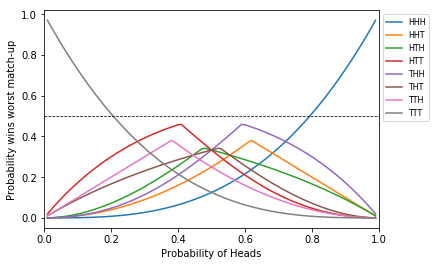

In [76]:
import matplotlib.pyplot as plt
import numpy as np

k = 3
#initialize the globals within the module
conway.list_pattern=['-']*k
conway.patterns = []

#build the patterns
conway.all_patterns(k,distribution)
patterns=conway.patterns

pHs = [i/100 for i in range(1,100)]

min_prob_each_pattern = [] 

#plt.gca().set_prop_cycle(None)

for pH in pHs:
    pT = 1-pH
    distribution={'H':pH, 'T':pT}
    
    min_probs = []
    for A in patterns:
        probABs = []
        for B in patterns:
            if A != B:
                probABs.append(conway.probAB(A,B,distribution))
            else:
                probABs.append(None)

        min_probAB = min(p for p in probABs if p is not None)
        min_probs.append(min_probAB)
    min_prob_each_pattern.append(min_probs)
    

#plt.figure(figsize=(8, 6),facecolor="white") 

#don't include gray borders
plt.figure(facecolor="white")
#plt.style.use('grayscale')

#don't incude negative x-axis
plt.xlim(0, 1)



#plot each graph
i = 0
for pattern in patterns:
         
        #make list x/y-values for plotting
        min_probs = [min_prob_each_pattern[j][i] for j in range(len(pHs)) ]
        plt.plot(pHs,min_probs,label=pattern)
        i +=1


#plot axis labels
#plt.ylabel('Expected Proportion')
#plt.xlabel('Number of shots')

#plot reference lines
plt.plot([0, 100], [.5, .5], 'k--',lw=.75)

#plot legend
plt.legend(bbox_to_anchor=(1, 1), loc=2,prop={'size': 8})


#plot axis labels
plt.ylabel('Probability wins worst match-up')
plt.xlabel('Probability of Heads')


#save figure
filename = 'win_worst_case_'+str(k)+'.pdf'
plt.savefig(filename, bbox_inches="tight");  

#plt.axis([0, 6, 0, 20])


What is the expected waiting time for the game to end given the first mover's strategy (when second mover best responds) vs. if the first mover were waiting alone for the pattern.

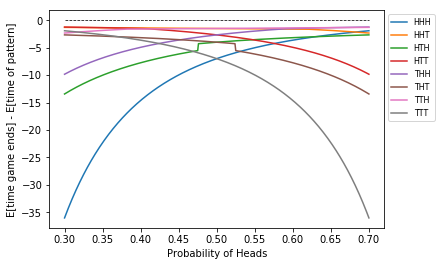

In [108]:
import matplotlib.pyplot as plt
import numpy as np
#help(conway)

#Difference in waiting time for each pattern, as a function of probability.

k = 3
#initialize the globals within the module
conway.list_pattern=['-']*k
conway.patterns = []

#build the patterns
pH =.5
pT = 1-pH
distribution={'H':pH, 'T':pT}
conway.all_patterns(k,distribution)
patterns=conway.patterns

pHs = [i/1000 for i in range(300,701)]
#print(pHs)
diff_wait_time = []

#plt.gca().set_prop_cycle(None)

for pH in pHs:
    pT = 1-pH
    distribution={'H':pH, 'T':pT}

    

    diff_waiting_time_A = []
    for A in patterns:
        probABs = []
        for B in patterns:
            if A != B:    
                probABs.append(conway.probAB(A,B,distribution))
            else:
                probABs.append(None)

      

        waiting_time_A = conway.expected_waiting_time(A,A,distribution) 
        
        #in case of times
        min_probAB = min(p for p in probABs if p is not None)
        min_indices = [i for i in range(len(probABs)) if probABs[i]==min_probAB]
        waiting_times_AminB =[]
        for i in min_indices:
            waiting_times_AminB.append(conway.expected_waiting_time(A,patterns[i],distribution))
        
        waiting_time_AB = min(waiting_times_AminB)
        
        diff_waiting_time_A.append(waiting_time_AB-waiting_time_A)
    
    diff_wait_time.append(diff_waiting_time_A)

#print(wait_time_pairs)


#plt.figure(figsize=(8, 6),facecolor="white") 

#don't include gray borders
#plt.figure(facecolor="white")
#plt.style.use('grayscale')

#don't incude negative x-axis
#plt.xlim(0, 50)



#plot each graph
i = 0
#plot each graph
i = 0
for pattern in patterns:
         
        #make list x/y-values for plotting
        y = [diff_wait_time[j][i] for j in range(len(pHs)) ]
        plt.plot(pHs,y,label=pattern)
        i +=1
        
        


#plot axis labels
#plt.ylabel('Expected Proportion')
#plt.xlabel('Number of shots')

#plot reference lines
plt.plot([.3, .7], [0, 0], 'k--',lw=.75)

#plot legend
plt.legend(bbox_to_anchor=(1, 1), loc=2,prop={'size': 8})


#plot axis labels
plt.ylabel('E[time game ends] - E[time of pattern]')
plt.xlabel('Probability of Heads')


#save figure
filename = 'waiting_time'+str(k)+'.pdf'
plt.savefig(filename, bbox_inches="tight");  